In [2]:
import pandas as pd
import boto3
import sagemaker

# Define S3 details
s3_bucket = "chicago-crime-buc"  
s3_key = "processed/chicago_crimes_filtered.csv"  
s3_uri = f"s3://{s3_bucket}/{s3_key}"

# Load dataset from S3
df = pd.read_csv(s3_uri)

# Convert 'Date' column back to datetime format
df['Date'] = pd.to_datetime(df['Date'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/27/25 01:32:46] INFO     Found credentials from IAM Role:                                   ]8;id=517822;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=282983;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:286: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


[04/27/25 01:32:52] INFO     Found credentials from IAM Role:                                   ]8;id=701420;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=151223;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [9]:
!pip install torch torchvision torchaudio
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 121.1 MB/s eta 0:00:00


In [12]:
!pip install leidenalg igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 116.2 MB/s eta 0:00:00


In [13]:
!pip install haversine

In [3]:
# Preprocessing
print("Original rows:", len(df))
df = df.dropna(subset=['Latitude', 'Longitude', 'Date'])
df['Date'] = pd.to_datetime(df['Date'])

# Optional: filter to a manageable timeframe
# df = df[df['Year'] >= 2020]

print("Rows after cleaning:", len(df))

Original rows: 19544
Rows after cleaning: 19544


In [4]:
# Step 2: Build Spatial Index with BallTree
# ------------------
import numpy as np
from sklearn.neighbors import BallTree

# Prepare coordinates
df = df.reset_index(drop=True)
coords = np.deg2rad(df[['Latitude', 'Longitude']].values)

# Create BallTree with Haversine distance
tree = BallTree(coords, metric='haversine')

In [5]:
# Step 3: Query Neighbors (Spatial + Optional Time Filter)
# ------------------
radius_km = 0.5  # 500 meters
radius = radius_km / 6371.0  # Earth radius in km

# Query neighbors
neighbors = tree.query_radius(coords, r=radius)

# Optional: Speed up time filtering by sorting by date
df = df.sort_values('Date').reset_index(drop=True)


In [6]:
# Step 4: Build Graph
# ------------------
import networkx as nx

G = nx.Graph()

# Add nodes with attributes
for idx, row in df.iterrows():
    G.add_node(idx, date=row['Date'], location=(row['Latitude'], row['Longitude']), primary_type=row['Primary Type'])

# Add edges based on spatial proximity (and optional time window)
time_window_hours = 1  # Only connect crimes within 1 hour

for i, neighbors_i in enumerate(neighbors):
    for j in neighbors_i:
        if i >= j:
            continue  # Avoid duplicate edges
        time_diff = abs((df.loc[i, 'Date'] - df.loc[j, 'Date']).total_seconds()) / 3600.0
        if time_diff <= time_window_hours:
            G.add_edge(i, j)

print("Graph built:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

Graph built: 19544 nodes, 1641 edges


In [7]:
# Step 5: Community Detection (Greedy Modularity)
# ------------------
import networkx as nx

communities = list(nx.algorithms.community.greedy_modularity_communities(G))

# Map nodes to community ids
node_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_community[node] = i



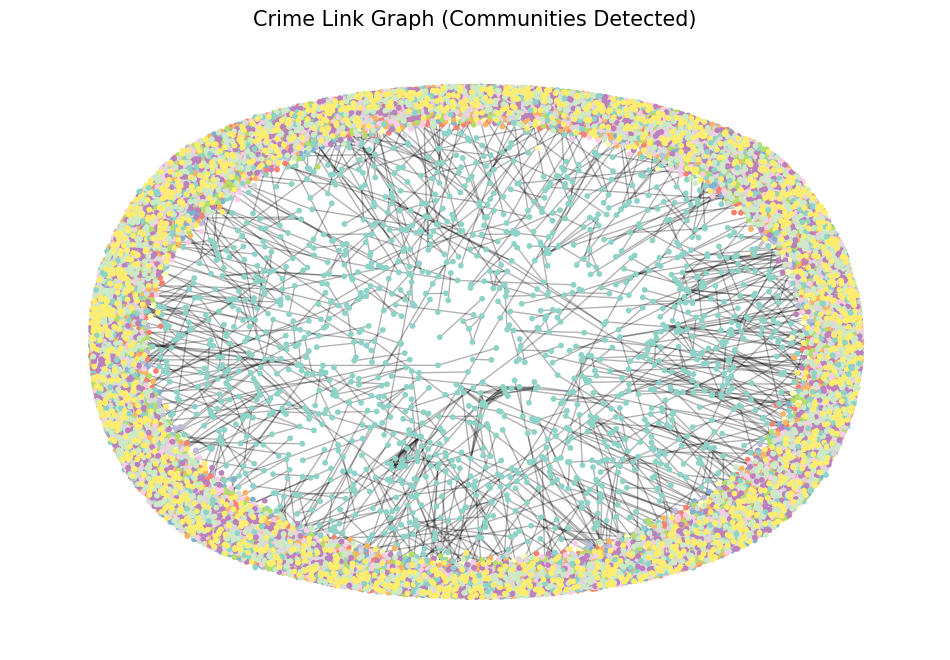

In [34]:
# ------------------
# Step 6: Visualization
# ------------------
import matplotlib.pyplot as plt

# Assign community ID as color
colors = [node_community.get(node) for node in G.nodes()]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.1)  # Layout optimized for bigger graphs
nx.draw_networkx_nodes(G, pos, node_size=10, cmap=plt.cm.Set3, node_color=colors)
nx.draw_networkx_edges(G, pos, alpha=0.3)

plt.title('Crime Link Graph (Communities Detected)', fontsize=15)
plt.axis('off')
plt.show()

Top 5 communities: [0, 1, 2, 3, 4]


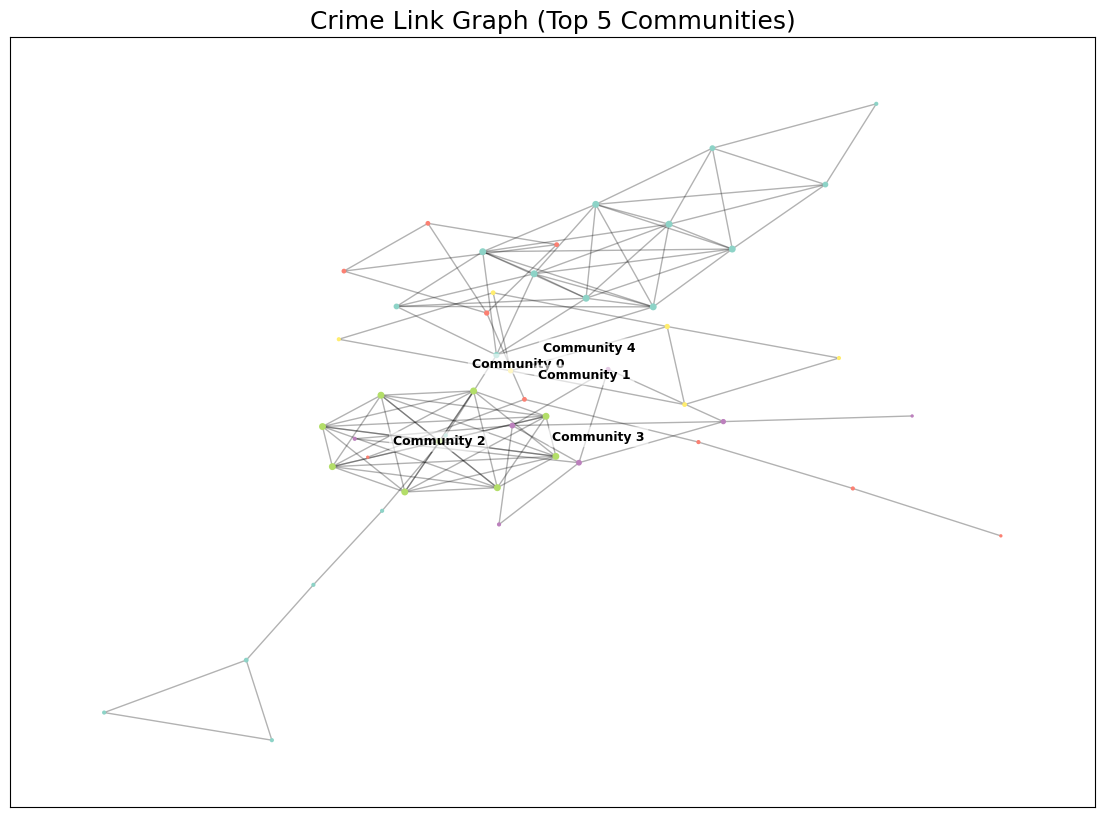

In [10]:
import collections
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Count size of each community
community_counts = collections.Counter(node_community.values())

#Get Top 5 biggest communities
top_5_communities = [comm for comm, count in community_counts.most_common(5)]
print("Top 5 communities:", top_5_communities)

#Filter nodes in only top 5 communities
top_nodes = [node for node, comm in node_community.items() if comm in top_5_communities]

# Step 4: Build subgraph
G_top = G.subgraph(top_nodes)

# Optional: sample if still too big
SAMPLE_SIZE = 1500
if G_top.number_of_nodes() > SAMPLE_SIZE:
    sampled_nodes = random.sample(list(G_top.nodes()), SAMPLE_SIZE)
    G_top = G_top.subgraph(sampled_nodes)
    print(f"Sampled {len(G_top.nodes)} nodes for visualization.")

#  Layout
pos = nx.kamada_kawai_layout(G_top)

# Assign colors
colors = [node_community.get(node) for node in G_top.nodes()]
node_sizes = [G_top.degree(node) * 2 for node in G_top.nodes()]

#Draw graph
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_top, pos, node_size=node_sizes, cmap=plt.cm.Set3, node_color=colors)
nx.draw_networkx_edges(G_top, pos, alpha=0.3)

#Label each community
for comm in top_5_communities:
    # Find nodes in this community
    comm_nodes = [node for node in G_top.nodes() if node_community.get(node) == comm]
    # Find their positions
    comm_pos = np.array([pos[node] for node in comm_nodes])
    # Find center
    center = comm_pos.mean(axis=0)
    # Put a label
    plt.text(center[0], center[1], f"Community {comm}", fontsize=9, weight='bold', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3'))

plt.title('Crime Link Graph (Top 5 Communities)', fontsize=18)
plt.axis('on')
plt.show()


Evaluation metrics

In [19]:
modularity = nx.algorithms.community.quality.modularity(G, communities)
print("Modularity Score:", modularity)


Modularity Score: 0.9975576343699994


In [20]:
# Average degree
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average Degree:", avg_degree)

# Average clustering coefficient
avg_clustering = nx.average_clustering(G)
print("Average Clustering Coefficient:", avg_clustering)

# Diameter (longest shortest path)
if nx.is_connected(G):
    diameter = nx.diameter(G)
    print("Diameter of Graph:", diameter)
else:
    print("Graph not fully connected; can't compute diameter directly.")


Average Degree: 0.1679287760949652
Average Clustering Coefficient: 0.013500428824825059
Graph not fully connected; can't compute diameter directly.


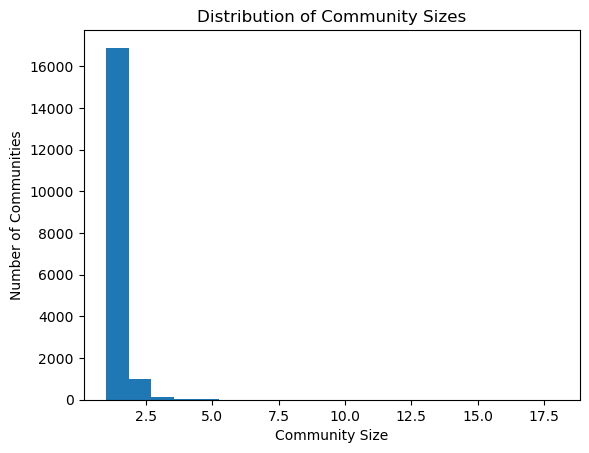

In [21]:
import matplotlib.pyplot as plt

community_sizes = [len(c) for c in communities]
plt.hist(community_sizes, bins=20)
plt.title("Distribution of Community Sizes")
plt.xlabel("Community Size")
plt.ylabel("Number of Communities")
plt.show()
